In [1]:
import os
import json
import pandas as pd
import numpy as np

In [2]:
RANDOM_STATE = 22
TARGET_FEATURE = 'winorlose'

# Pré-processamento

In [3]:
def fix_col_names(_df: pd.DataFrame, silent: bool = True) -> pd.DataFrame:
    ''' Strips and lowercases DataFrame columns '''
    df = _df.copy()
    og_cols = df.columns.to_list()

    df.columns = df.columns \
        .str.lower() \
        .str.strip()
    
    max_col_name_size = len(max(og_cols, key=lambda x: len(x))) + 5
    if not silent:
        for og, new in zip(og_cols, df.columns.to_list()):
            print(f'{og: <{max_col_name_size}} -> {new}')

    return df

In [4]:
def prepare_playoff_dataframe(_df: pd.DataFrame) -> pd.DataFrame:
    df = _df.copy()
    cols_to_drop = [
        'gs_overtime', 'gs_pts_off', 'gs_pts_def',
        'gs_first_down_off', 'gs_yards_off', 'gs_pass_yds_off',
        'gs_rush_yds_off', 'gs_to_off', 'gs_first_down_def',
        'gs_yards_def', 'gs_pass_yds_def', 'gs_rush_yds_def',
        'gs_to_def', 'gs_exp_pts_off', 'gs_exp_pts_def', 'gs_exp_pts_st',
        'gs_is_playoff', 'gs_team_record',
        'hts_year', 'hts_team', 'hts_team.1',
        'ats_year', 'ats_team', 'ats_team.1', 'Unnamed: 0'
    ]
    df.drop(cols_to_drop, axis=1, inplace=True)
    df = df[df['gs_game_location'].isin(['N', 'home'])]

    # renaming cols
    cols_to_rename = {
        'gs_game_outcome': 'winorlose'
    }
    df.rename(cols_to_rename, axis=1, inplace=True)

    # reordering
    # new_col_order = ['gs_id', 'gs_year', 'gs_team', 'gs_opp']
    # new_col_order += df.drop(new_col_order + ['winorlose'], axis=1).columns.tolist() + ['winorlose']
    # df = df[new_col_order]
    
    return df

In [5]:
def preprocess(
    df_raw: pd.DataFrame,
    target: str
) -> pd.DataFrame:
    
    # col names
    df = df_raw.copy()
    df = fix_col_names(df)
    
    # bool to numeric
    non_numeric_or_object = df.select_dtypes(exclude=[np.number, object]).columns
    df[non_numeric_or_object] = df[non_numeric_or_object].astype(int)

    # cols with values that contain '%' or 'Own' to numeric
    for col in df.select_dtypes(object).columns:
        if any(df[col].str.contains('Own', na=False)):
            df[col] = df[col].str.extract('[Own]?(\d+.\d*)').astype(float)
            continue
        if any(df[col].str.contains('%', na=False)):
            df[col] = df[col].str.extract('(\d+.\d*)[%]').astype(float)
            continue
    
    # remove columns with values that contain ':' or '-'
    for col in df.select_dtypes(object).columns:
        if any(df[col].str.contains(':', na=False)):
            df.drop(col, axis=1, inplace=True)
            continue
        if any(df[col].str.contains('-', na=False)):
            df.drop(col, axis=1, inplace=True)
            continue

    target_encoder = {'L': 0, 'W': 1}
    df[target] = df[target].map(target_encoder)
            
    return df

# Calculo das métricas da predição

In [6]:
from pprint import pprint
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, balanced_accuracy_score, precision_score, recall_score
from datetime import datetime

all_scores = {}

def show_scores(scores: dict = all_scores):
    display(pd.DataFrame(all_scores.values()))

def calculate_scores(
    model_name: str, 
    y_test: pd.Series, pred: np.ndarray, 
    pos_label: str or int = 1,
    score_list: list = all_scores,
    display_confusion_matrix: bool = True,
    display_scores: bool = True
    ):
    cf_mx = ConfusionMatrixDisplay.from_predictions(y_test, pred)
    acc = accuracy_score(y_test, pred)
    bacc = balanced_accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred, pos_label=pos_label)
    recall = recall_score(y_test, pred, pos_label=pos_label)
    
    model_scores = {
        'model_name': model_name,
        'acc': acc,
        'bacc': bacc,
        'precision': precision,
        'recall': recall
    }
    score_list[model_name] = model_scores
    
    if display_confusion_matrix:
        display(cf_mx)   
    if show_scores:
        show_scores(score_list)
    return model_scores

# Carregamento & processamento dos dados

## Dados completos

In [7]:
for dirname, _, files in os.walk('/kaggle/input'):
    for file in files:
        print(os.path.join(dirname, file))

/kaggle/input/nfl-playoffs-19702021/df_kaggle_test.csv
/kaggle/input/nfl-playoffs-19702021/playoffs.csv
/kaggle/input/nfl-playoffs-19702021/df_kaggle_test_labels.csv
/kaggle/input/nfl-playoffs-19702021/df_kaggle_train.csv


In [8]:
df_playoffs_raw = pd.read_csv('/kaggle/input/nfl-playoffs-19702021/playoffs.csv', sep=';')
df_playoffs = prepare_playoff_dataframe(df_playoffs_raw)

df_playoffs_raw.shape, df_playoffs.shape

((1052, 288), (578, 263))

In [9]:
df_playoffs = preprocess(df_playoffs, TARGET_FEATURE)

# *Feature selection*

## Por correlaçao com o alvo 

In [10]:
# correlated_features = df_playoffs.corrwith(df_playoffs['winorlose']).sort_values(ascending=False)[1:21]

## Treino e teste

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
# df_train = df_playoffs[df_playoffs['gs_year'] <= 2017]
# df_test =  df_playoffs[df_playoffs['gs_year'] > 2017]
df_train = df_playoffs.copy()
df_train.sort_values('gs_year', ascending=True, inplace=True)

In [13]:
x = df_train.drop(TARGET_FEATURE, axis=1)
y = df_train[TARGET_FEATURE]

In [14]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=RANDOM_STATE, shuffle=False)

In [15]:
print(f'Treino\n\tx: {x_train.shape}\n\ty: {y_train.shape}')
print(f'Teste\n\tx: {x_test.shape}\n\ty: {y_test.shape}')
print(f'Target no treino: {TARGET_FEATURE in x_train.columns}')
print(f'Target no teste: {TARGET_FEATURE in x_test.columns}')

Treino
	x: (520, 259)
	y: (520,)
Teste
	x: (58, 259)
	y: (58,)
Target no treino: False
Target no teste: False


# Pipeline para limpeza e *scaling*

In [16]:
from sklearn.pipeline import make_pipeline, FeatureUnion
from sklearn.preprocessing import RobustScaler, OrdinalEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.impute import SimpleImputer

In [17]:
preprocess_pipeline = make_column_transformer(
    (SimpleImputer(strategy='mean', fill_value='constant'), make_column_selector(dtype_include=np.number)),
    (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), make_column_selector(dtype_include=object))
)

# Funçoes auxiliares
   - Gerar prediçoes
   - Gerar, salvar e ler hiperparametros
   - Mostrar *feature importances*

In [18]:
def generate_predictions(
    clf, clf_name: str, 
    x_train: pd.DataFrame = x_train, y_train: pd.DataFrame = y_train,
    x_test: pd.DataFrame = x_test, y_test: pd.DataFrame = y_test,
    fit_params: dict = {}
):
    model = make_pipeline(
        preprocess_pipeline,
        RobustScaler(),
        clf
    )
    model.fit(x_train, y_train, **fit_params)
    
    pred = model.predict(x_test)
    pred = [0 if p <= 0.5 else 1 for p in pred]

    scores = calculate_scores(clf_name, y_test, pred)
    
    return scores, model

In [19]:
from sklearn.model_selection import RandomizedSearchCV

def save_hyperparameters(name: str, grid: RandomizedSearchCV):
    grid_info = {
        name: {**grid.best_params_, 'best_score': grid.best_score_}
    }

    filename = 'hyperparameters.json'
    if not os.path.exists(filename):
        with open(filename, 'w') as file: 
            file.write('{}')
        data = {}
    else:
        with open(filename, 'r') as file:
            data = json.loads(file.read())

    data.update(grid_info)

    with open(filename, 'w') as file:
        json.dump(data, file)

In [20]:
def read_hyperparameters() -> dict:
    filename = 'hyperparameters.json'
    if not os.path.exists(filename):
        with open(filename, 'w') as file: 
            file.write('{}')
        data = {}
    else:
        with open(filename, 'r') as file:
            data = json.loads(file.read())

    return data

In [21]:
def generate_hyperparameters(
    clf, clf_name: str,
    x_train: pd.DataFrame = x_train, 
    y_train: pd.DataFrame = y_train,
    *,
    params_grid: dict,
    fit_params: dict = {}
):

    grid = RandomizedSearchCV(
        estimator=clf,
        param_distributions=params_grid,
        scoring='balanced_accuracy',
        n_iter=100,
        cv=5,
        verbose=2,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )

    model = make_pipeline(
        preprocess_pipeline,
        RobustScaler(),
        grid
    )
    model.fit(x_train, y_train, **fit_params)

    save_hyperparameters(clf_name, model[-1])

    return grid

In [22]:
def get_feature_importances(clf, x_train: pd.DataFrame) -> pd.DataFrame:
    assert hasattr(clf, 'feature_importances_')

    importances = clf.feature_importances_
    features = x_train.columns

    feature_importances = pd.DataFrame({'feature': features, 'importance': importances})

    return feature_importances

# Random Forest Classifier

In [23]:
from sklearn.ensemble import RandomForestClassifier

## Básico 

In [24]:
x_train['gs_year'].unique(), x_test['gs_year'].unique()

(array([1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980,
        1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991,
        1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002,
        2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
        2014, 2015, 2016, 2017]),
 array([2017, 2018, 2019, 2020, 2021]))

,model_name,acc,bacc,precision,recall
0,rfc_basic,0.568966,0.504848,0.5,0.04


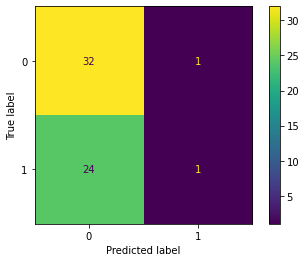

In [25]:
rfc = RandomForestClassifier(random_state=RANDOM_STATE)
rfc_scores, rfc_pipeline = generate_predictions(rfc, 'rfc_basic')

In [26]:
get_feature_importances(rfc, x_train).sort_values('importance', ascending=False)

,feature,importance
10,hts_wins,0.014017
44,hts_score_pct,0.012520
15,hts_points_opp,0.012175
13,hts_win_loss_perc,0.011645
62,hts_exp_pts_pass,0.010897
...,...,...
105,hts_rushtd,0.000193
16,hts_points_diff,0.000165
141,ats_points_diff,0.000028
109,hts_frtd,0.000000


## n_estimators=500, criterion='entropy', max_features='sqrt'

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,model_name,acc,bacc,precision,recall
0,rfc_basic,0.568966,0.504848,0.5,0.04
1,rfc_tuned,0.568966,0.500000,0.0,0.00


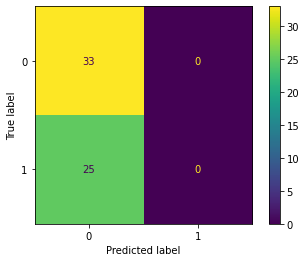

In [27]:
rfc_tuned = RandomForestClassifier(n_estimators=500, criterion='entropy', max_features='sqrt', random_state=RANDOM_STATE)
rfc_tuned_scores, rfc_tuned_pipeline = generate_predictions(rfc_tuned, 'rfc_tuned')

## GridSearch 

In [28]:
n_estimators = [50, 100, 250, 500]
max_features = ['auto', 'sqrt']
max_depth = [10, 25, 50, 100]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

rfc_param_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap
}

In [29]:
rfc_grid_model = RandomForestClassifier(random_state=RANDOM_STATE)

rfc_grid = generate_hyperparameters(rfc_grid_model, 'grid_rfc', params_grid=rfc_param_grid)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; t

## Melhores parâmetros 

,model_name,acc,bacc,precision,recall
0,rfc_basic,0.568966,0.504848,0.500000,0.04
1,rfc_tuned,0.568966,0.500000,0.000000,0.00
2,rfc_best_params,0.551724,0.489697,0.333333,0.04


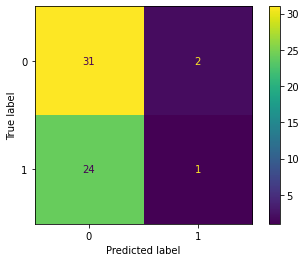

In [30]:
rfc_best_params = RandomForestClassifier(
    **rfc_grid.best_params_,
    random_state=RANDOM_STATE
)
rfc_best_params_scores, rfc_best_params_pipeline = generate_predictions(rfc_best_params, 'rfc_best_params')

# Support Vector Classifier

In [31]:
from sklearn.svm import SVC

## Básico

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,model_name,acc,bacc,precision,recall
0,rfc_basic,0.568966,0.504848,0.500000,0.04
1,rfc_tuned,0.568966,0.500000,0.000000,0.00
2,rfc_best_params,0.551724,0.489697,0.333333,0.04
3,svc_basic,0.568966,0.500000,0.000000,0.00


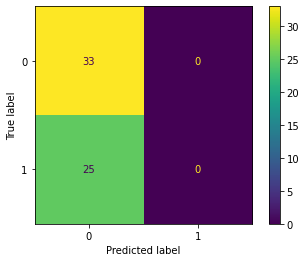

In [32]:
svc = SVC(random_state=RANDOM_STATE)
svc_scores, svc_pipeline = generate_predictions(svc, 'svc_basic')

## kernel='poly', degree=6, gamma=1, C=0.1

,model_name,acc,bacc,precision,recall
0,rfc_basic,0.568966,0.504848,0.500000,0.04
1,rfc_tuned,0.568966,0.500000,0.000000,0.00
2,rfc_best_params,0.551724,0.489697,0.333333,0.04
3,svc_basic,0.568966,0.500000,0.000000,0.00
4,svc_poly,0.500000,0.468485,0.375000,0.24


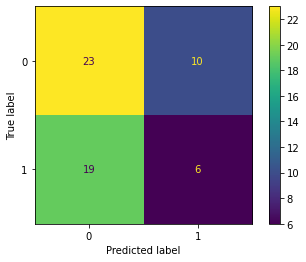

In [33]:
svc_poly = SVC(kernel='poly', degree=6, gamma=1, C=0.1, random_state=RANDOM_STATE)
svc_poly_scores, svc_poly_pipeline = generate_predictions(svc_poly, 'svc_poly')

## GridSearch

In [34]:
svc_param_grid = {
    'C': [0.1, 1, 100, 1000],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'poly'],
    'degree': [3, 4, 5, 6]
}

In [35]:
svc_grid_model = SVC(random_state=RANDOM_STATE)

svc_grid = generate_hyperparameters(svc_grid_model, 'grid_svc', params_grid=svc_param_grid)

Fitting 5 folds for each of 100 candidates, totalling 500 fits

[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=250; total time=   1.4s
[CV] END bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.7s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   3.8s
[CV] END bootstrap=False, max_depth=25, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.4s
[CV] END bootstrap=False, max_depth=25, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=250; total time=   1.6s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimator

## Melhores parâmetros 

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,model_name,acc,bacc,precision,recall
0,rfc_basic,0.568966,0.504848,0.500000,0.04
1,rfc_tuned,0.568966,0.500000,0.000000,0.00
2,rfc_best_params,0.551724,0.489697,0.333333,0.04
3,svc_basic,0.568966,0.500000,0.000000,0.00
4,svc_poly,0.500000,0.468485,0.375000,0.24
5,svc_best_params,0.568966,0.500000,0.000000,0.00


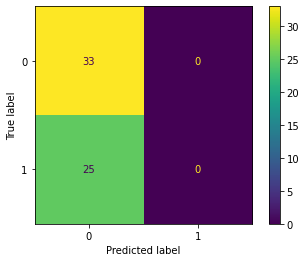

In [36]:
svc_best_params = SVC(**svc_grid.best_params_, random_state=RANDOM_STATE)
svc_best_params_scores, svc_best_params_pipeline = generate_predictions(svc_best_params, 'svc_best_params')

# Gaussian Naive Bayes

In [37]:
from sklearn.naive_bayes import GaussianNB

,model_name,acc,bacc,precision,recall
0,rfc_basic,0.568966,0.504848,0.500000,0.04
1,rfc_tuned,0.568966,0.500000,0.000000,0.00
2,rfc_best_params,0.551724,0.489697,0.333333,0.04
3,svc_basic,0.568966,0.500000,0.000000,0.00
4,svc_poly,0.500000,0.468485,0.375000,0.24
5,svc_best_params,0.568966,0.500000,0.000000,0.00
6,gaussian_nb_basic,0.568966,0.524242,0.500000,0.20


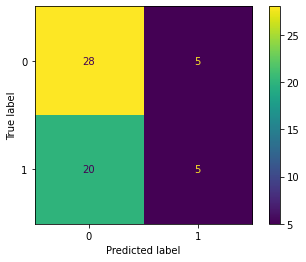

In [38]:
gaussian_nb = GaussianNB()
gaussian_nb_scores, gaussian_nb_pipeline = generate_predictions(gaussian_nb, 'gaussian_nb_basic')

## GridSearch

In [39]:
nb_param_grid = {'var_smoothing': np.logspace(0,-9, num=100)}

In [40]:
nb_grid_model = GaussianNB()

nb_grid = generate_hyperparameters(nb_grid_model, 'grid_nb', params_grid=nb_param_grid)

Fitting 5 folds for each of 100 candidates, totalling 500 fits

[CV] END ..............C=0.1, degree=5, gamma=1, kernel=poly; total time=   0.4s
[CV] END ..............C=0.1, degree=5, gamma=1, kernel=poly; total time=   0.4s
[CV] END ..............C=0.1, degree=4, gamma=1, kernel=poly; total time=   0.3s
[CV] END .............C=1, degree=5, gamma=0.01, kernel=poly; total time=   0.9s
[CV] END .............C=1, degree=5, gamma=0.01, kernel=poly; total time=   0.4s
[CV] END ...........C=0.1, degree=5, gamma=0.01, kernel=poly; total time=   0.5s
[CV] END ..............C=100, degree=3, gamma=1, kernel=poly; total time=   1.5s
[CV] END ..............C=1, degree=6, gamma=0.1, kernel=poly; total time=   0.4s
[CV] END ..............C=1, degree=6, gamma=0.1, kernel=poly; total time=   0.6s
[CV] END ..............C=1, degree=6, gamma=0.01, kernel=rbf; total time=   0.1s
[CV] END ...............C=1, degree=6, gamma=0.1, kernel=rbf; total time=   0.1s
[CV] END ............C=1000, degree=6, gamma=

## Melhores parâmetros 

,model_name,acc,bacc,precision,recall
0,rfc_basic,0.568966,0.504848,0.500000,0.04
1,rfc_tuned,0.568966,0.500000,0.000000,0.00
2,rfc_best_params,0.551724,0.489697,0.333333,0.04
3,svc_basic,0.568966,0.500000,0.000000,0.00
4,svc_poly,0.500000,0.468485,0.375000,0.24
5,svc_best_params,0.534483,0.513333,0.450000,0.36
6,gaussian_nb_basic,0.568966,0.524242,0.500000,0.20


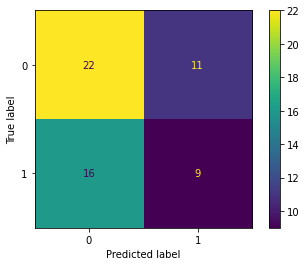

In [41]:
nb_best_params = GaussianNB(**nb_grid.best_params_)
nb_best_params_scores, nb_best_params_pipeline = generate_predictions(nb_best_params, 'svc_best_params')

# Multi-layer perceptron
a.k.a sklearn's neural network

In [42]:
from sklearn.neural_network import MLPClassifier

## Básico

/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


,model_name,acc,bacc,precision,recall
0,rfc_basic,0.568966,0.504848,0.500000,0.04
1,rfc_tuned,0.568966,0.500000,0.000000,0.00
2,rfc_best_params,0.551724,0.489697,0.333333,0.04
3,svc_basic,0.568966,0.500000,0.000000,0.00
4,svc_poly,0.500000,0.468485,0.375000,0.24
5,svc_best_params,0.534483,0.513333,0.450000,0.36
6,gaussian_nb_basic,0.568966,0.524242,0.500000,0.20
7,mlp_basic,0.586207,0.544242,0.545455,0.24


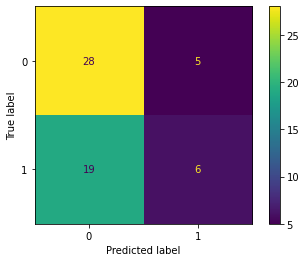

In [43]:
mlp = MLPClassifier(random_state=RANDOM_STATE)
mlp_scores, mlp_pipeline = generate_predictions(mlp, 'mlp_basic')

## GridSearch

In [44]:
mlp_param_grid = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,), (100, 100, 100)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
    'max_iter': [200, 500, 1000]
}

In [45]:
mlp_grid_model = MLPClassifier(random_state=RANDOM_STATE)

mlp_grid = generate_hyperparameters(mlp_grid_model, 'grid_mlp', params_grid=mlp_param_grid)

Fitting 5 folds for each of 100 candidates, totalling 500 fits

[CV] END ...............var_smoothing=4.3287612810830526e-07; total time=   0.0s
[CV] END ...............var_smoothing=4.3287612810830526e-07; total time=   0.0s
[CV] END ...............var_smoothing=3.5111917342151277e-07; total time=   0.0s
[CV] END ...............var_smoothing=3.5111917342151277e-07; total time=   0.0s
[CV] END ...............var_smoothing=3.5111917342151277e-07; total time=   0.0s
[CV] END ...............var_smoothing=3.5111917342151277e-07; total time=   0.0s
[CV] END ...............var_smoothing=3.5111917342151277e-07; total time=   0.0s
[CV] END ................var_smoothing=2.848035868435799e-07; total time=   0.0s
[CV] END ................var_smoothing=2.848035868435799e-07; total time=   0.0s
[CV] END ................var_smoothing=2.848035868435799e-07; total time=   0.0s
[CV] END ................var_smoothing=2.848035868435799e-07; total time=   0.0s
[CV] END ................var_smoothing=2.8480

/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multi

In [46]:
mlp_grid.best_params_

{'solver': 'sgd',
 'max_iter': 500,
 'learning_rate': 'constant',
 'hidden_layer_sizes': (100,),
 'alpha': 0.05,
 'activation': 'tanh'}

## Melhores parâmetros

/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


,model_name,acc,bacc,precision,recall
0,rfc_basic,0.568966,0.504848,0.500000,0.04
1,rfc_tuned,0.568966,0.500000,0.000000,0.00
2,rfc_best_params,0.551724,0.489697,0.333333,0.04
3,svc_basic,0.568966,0.500000,0.000000,0.00
4,svc_poly,0.500000,0.468485,0.375000,0.24
5,svc_best_params,0.534483,0.513333,0.450000,0.36
6,gaussian_nb_basic,0.568966,0.524242,0.500000,0.20
7,mlp_basic,0.586207,0.544242,0.545455,0.24
8,mlp_best_params,0.534483,0.523030,0.458333,0.44


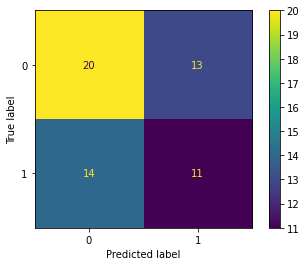

In [47]:
mlp_best_params = MLPClassifier(**mlp_grid.best_params_, random_state=RANDOM_STATE)
mlp_best_params_scores, mlp_best_params_pipeline = generate_predictions(mlp_best_params, 'mlp_best_params')

# Keras sequential

In [48]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten

In [49]:
keras_nn = Sequential()
keras_nn.add(Dense(128, input_dim=x_train.shape[1], activation='relu'))

keras_nn.add(Dense(256, activation='relu'))
keras_nn.add(Dense(256, activation='relu'))
keras_nn.add(Dense(256, activation='relu'))

keras_nn.add(Dense(1, activation='sigmoid'))

keras_nn.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics='accuracy'
)

keras_nn.summary()

2022-09-01 00:00:18.422694: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               33280     
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 198,145
Trainable params: 198,145
Non-trainable params: 0
_________________________________________________________________


In [50]:
keras_nn_fit_params = {
    'sequential__epochs': 500,
    'sequential__batch_size': 32,
    'sequential__verbose': 0, 
}

2022-09-01 00:00:19.146103: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


,model_name,acc,bacc,precision,recall
0,rfc_basic,0.568966,0.504848,0.500000,0.04
1,rfc_tuned,0.568966,0.500000,0.000000,0.00
2,rfc_best_params,0.551724,0.489697,0.333333,0.04
3,svc_basic,0.568966,0.500000,0.000000,0.00
4,svc_poly,0.500000,0.468485,0.375000,0.24
5,svc_best_params,0.534483,0.513333,0.450000,0.36
6,gaussian_nb_basic,0.568966,0.524242,0.500000,0.20
7,mlp_basic,0.586207,0.544242,0.545455,0.24
8,mlp_best_params,0.534483,0.523030,0.458333,0.44
9,keras_sequencial,0.620690,0.579394,0.636364,0.28


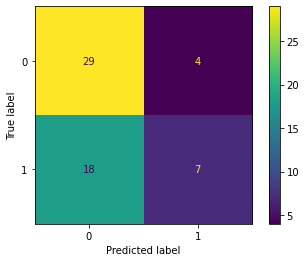

In [51]:
keras_nn_scores, keras_nn_pipeline = generate_predictions(keras_nn, 'keras_sequencial', fit_params=keras_nn_fit_params)

---

In [52]:
pd.DataFrame(all_scores.values())

,model_name,acc,bacc,precision,recall
0,rfc_basic,0.568966,0.504848,0.500000,0.04
1,rfc_tuned,0.568966,0.500000,0.000000,0.00
2,rfc_best_params,0.551724,0.489697,0.333333,0.04
3,svc_basic,0.568966,0.500000,0.000000,0.00
4,svc_poly,0.500000,0.468485,0.375000,0.24
5,svc_best_params,0.534483,0.513333,0.450000,0.36
6,gaussian_nb_basic,0.568966,0.524242,0.500000,0.20
7,mlp_basic,0.586207,0.544242,0.545455,0.24
8,mlp_best_params,0.534483,0.523030,0.458333,0.44
9,keras_sequencial,0.620690,0.579394,0.636364,0.28


In [53]:
pd.DataFrame(all_scores.values()).to_csv('models.csv')